# Development version 17.3.21:1200

In [1]:
import numpy as np

# This method finds the location of all peaks in the full spectrum
# Output (Indices) contains the start index and end index of each peak

def findAllPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2))
    
#    print(sum(data[:,1] == 0))  # if this was 217 => n=108
# n is the number of zeros/2 (but that is not the final count..)
# output is index ranges: each peak starts and ends with a zero
# so that there are two zeros between each peak

    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0

    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])  # notice '='
#    print(last)  = 106
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
#    print(len(indices))   # why now 107?
# OK, if you have only one zero, then it is not a separation mark for peaks 
    return indices

# Essentially same as JKo 4.3.

In [155]:
#import numpy as np
#import pandas as pd
#
#def readFile(fileName):
#    return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")

# New 4.3.

In [77]:
from scipy.optimize import leastsq
import numpy as np
import math

def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])  # painotettu keskiarvo

#    sigma = (mu/280000)/(2*np.log(2))    # was Koli
#    fitfunc  = lambda p, x: p[0]*np.exp(-((x-p[1])/(2*sigma))**2)   # was Koli    

    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)

    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]

    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))                 
    c = out[0]
    return c[1]

# 4.3. JKo corrected 17.3. by KO

In [3]:
import numpy as np

def getAllMeans(peaks,indices):
#    indices = findAllPeakIndices(peaks)
    n = len(indices)  

    means = np.zeros(n)
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        means[i] = getMean(peak)
    return means

# JKo 4.3. modified by KOj 8.3.

In [4]:
import numpy as np

def getArea(peak):
    sum = np.sum(peak[:,1])
    width = peak[len(peak)-1,0]-peak[0,0]
#    print(sum)
#    print(width)
    return sum*width

# KO 8.3.

In [5]:
import pandas as pd
import numpy as np

def getAllAreas(data, indices):
#def getAllAreas(data, peaklist, identified):

    n = len(indices)
    areas = np.zeros(n)
    for i in range(n):
        peak = data[indices[i,0]:indices[i,1]+1,:]
        areas[i] = getArea(peak)

    return areas

# KO 8.3.

In [6]:
import numpy as np
# from scipy.stats import kurtosis, skew
import pandas as pd

# initialize list of lists 
#data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# Create the pandas DataFrame 
#df = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# print dataframe. 
#df 


def getSkew(peak):
    data=peak[:,1]
    df = pd.DataFrame(data, columns = ['Hits'])
#    print(df.skew(axis = 0))
    skw = df.skew(axis = 0)

    return skw

# KO 9.3.

In [7]:
import pandas as pd
import numpy as np

def getAllSkews(data, indices):

    n = len(indices)
    skews = np.zeros(n)
    for i in range(n):
        peak = data[indices[i,0]:indices[i,1]+1,:]
        skews[i] = getSkew(peak)

    return skews

# KO 9.3.

In [39]:
import pandas as pd
import numpy as np

def identifyPeaks(data, peakMeans, peakAreas, peakSkews, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peaklist['area'] = np.zeros(len(peaklist['mz']))  
    peaklist['skew'] = np.zeros(len(peaklist['mz']))
##    peaklist['idx'] = np.zeros(len(peaklist['mz'])) 
    
    trueValue = peaklist['mz'].to_numpy()     # grab only mz values from the peaklist
#    print("len trueV ",len(trueValue))
#    print("len areas ",len(peakAreas))
#    print("len means ",len(peakMeans))
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:      # there is at least one
            ind = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[ind]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,4] = peakAreas[ind]
            peaklist.iloc[i,5] = peakSkews[ind]
##            peaklist.iloc[i,6] = peaklist.index.to_numpy()            
# np.argmin: Returns the indices of the minimum values along an axis.   

    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
  
    identified = np.linspace(0, len(trueValue)-1, len(trueValue))
    identified = identified[peaklist['observed'].to_numpy() != 0]    

#    unidentified: observed is 0, because never got a new value

    newpeaklist = peaklist.drop(unidentified)
    print("Number of final peaks: ",len(newpeaklist))
    print(newpeaklist)
    return newpeaklist

# New 4.3.  modified by KO 8.3.

In [17]:
# Method to read in one spectrum
# A large number of averaged, denoised spectra are exported from Orbitool into folders
# Exported with Antonio's "all denoised" button

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import glob

def readSpectrum(n):
    dataDir = glob.glob("C:/datascienceproject/raw data/small mass deviation/deno201117n10/*.csv")
    fileName = dataDir[n]
    print("File name: ",fileName)
    df = pd.read_csv(fileName, sep=",")  # possible that 'sep' is not necessary here

    print("Shape: {}, {}".format(*df.shape))
    print()
    print()
#print(df.iloc[0:3,:2])# Zero works here
    data = df.iloc[0:,:2].to_numpy().astype("float64")

#fileName = "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv"  # JKoli's
#return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64") JKo

    return(data)
# New 4.3. was modified 8.3. by KO


File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-38.csv
Shape: 1695, 2


Number of final peaks:  80
         formula          mz    observed  peak           area      skew
1           O3N-   61.988366   61.987217   3.0  135013.124688  7.808247
2       O3N[15]-   62.985401   62.985425   7.0      18.043591  0.948547
3      O2O[17]N-   62.992584   62.992610   8.0       5.774912  0.906888
4      O2O[18]N-   63.992613   63.992626   9.0      40.694883  1.075982
9         C2HO4-   88.988032   88.988123  12.0      10.202756  0.923892
..           ...         ...         ...   ...            ...       ...
266   C11H16O9N-  306.083055  306.082956  92.0       2.681241  0.343627
269  C10H14O10N-  308.062319  308.062309  93.0      17.935707  0.546700
274  C10H16O10N-  310.077969  310.077769  94.0      10.935164  0.130840
279  C11H16O10N-  322.077969  322.077918  95.0       2.598019  0.280398
282  C10H14O11N-  324.057234  324.057064  96.0       1.240492 

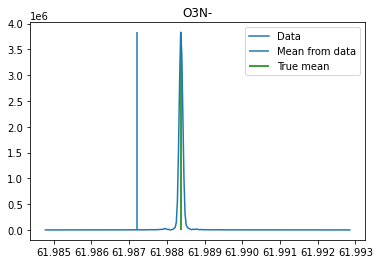

         formula          mz    observed  peak           area      skew  idx
1           O3N-   61.988366   61.987217   3.0  135013.124688  7.808247    1
2       O3N[15]-   62.985401   62.985425   7.0      18.043591  0.948547    2
3      O2O[17]N-   62.992584   62.992610   8.0       5.774912  0.906888    3
4      O2O[18]N-   63.992613   63.992626   9.0      40.694883  1.075982    4
9         C2HO4-   88.988032   88.988123  12.0      10.202756  0.923892    9
..           ...         ...         ...   ...            ...       ...  ...
266   C11H16O9N-  306.083055  306.082956  92.0       2.681241  0.343627  266
269  C10H14O10N-  308.062319  308.062309  93.0      17.935707  0.546700  269
274  C10H16O10N-  310.077969  310.077769  94.0      10.935164  0.130840  274
279  C11H16O10N-  322.077969  322.077918  95.0       2.598019  0.280398  279
282  C10H14O11N-  324.057234  324.057064  96.0       1.240492 -0.332631  282

[80 rows x 7 columns]


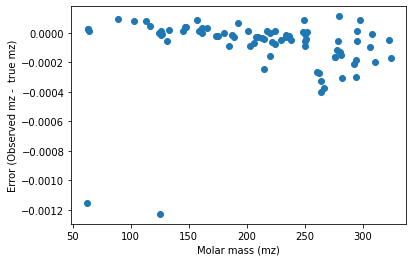

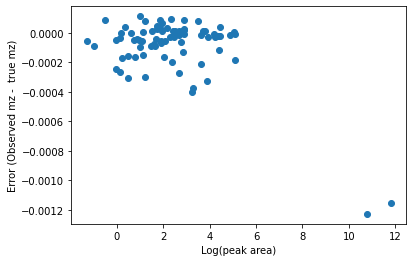

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


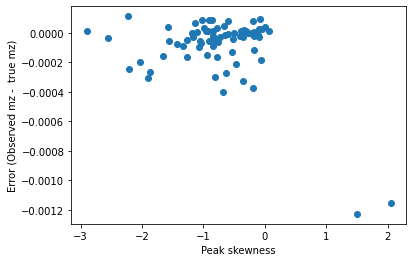


If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Negative skewness: peak top is to the right from the mean (bigger tail on the left).


In [217]:
# Plot a peak etc.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# this short method not working
def add_labels(line):
    x,y=line.get_data()
    labels=map(','.join,zip(map(lambda s: '%g'%s,x),map(lambda s: '%g'%s,y)))
    map(plt.text,x,y,labels)

data = readSpectrum(3)    # Read the nth file in the folder of spectra
peakindices = findAllPeakIndices(data)
peakMeans = getAllMeans(data,peakindices)
peakAreas = getAllAreas(data,peakindices)
peakSkews = getAllSkews(data,peakindices)

#peaklist = pd.read_csv("peaklist.csv")             # was JKo
#peaklist = identifyPeaks(data, peaklist, 0.002)    # was JKo

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"
ionFileName = ionFolder + "Allions1ex.csv"
peaklist = identifyPeaks(data, peakMeans, peakAreas, peakSkews, pd.read_csv(ionFileName, sep=","), 0.002)

# Choose peak   ( i:th peak from the left in the graph, i starts from zero)
i = 0
ii = int(peaklist.iloc[i,3])
peak = data[peakindices[ii,0]:peakindices[ii,1]+1]

plt.plot(peak[:,0],peak[:,1])
plt.vlines(peaklist.iloc[i,2],0,max(peak[:,1]))
plt.vlines(peaklist.iloc[i,1],0,max(peak[:,1]), color = "green")
plt.legend(["Data","Mean from data","True mean"])
plt.title(peaklist.iloc[i,0])
plt.show()

peaklist['idx'] = peaklist.index.to_numpy()    # Index becomes column 6, too
#print(peaklist.iloc[:,4:7])
print(peaklist)

xmz = peaklist.iloc[:,1]
ydiff = peaklist.iloc[:,2]-peaklist.iloc[:,1]
#nam = peaklist.iloc[:,3].astype(int) # this idea not working yet, so:
nam = peaklist.iloc[:,0]
pit = len(xmz)

y = ydiff[:pit]
x = xmz[:pit]
k = nam[:pit]
fig = plt.figure()
#ax = fig.add_subplot(111)   # not working
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these lines:
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Observed mz -  true mz)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()


ylogarea = np.log(peaklist.iloc[:,4])
#plt.scatter(ylogarea,ydiff)   # Old vers
#plt.show()                    # Old vers
x = ylogarea[:pit]
y = ydiff[:pit]
k = nam[:pit]
fig = plt.figure()
#ax = fig.add_subplot(111)  # not working
plt.scatter(x,y)
# To see the names of compounds in the graph, uncomment these lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

xskew = np.log(peaklist.iloc[:,5])
x = xskew[:pit]
y = ydiff[:pit]
k = nam[:pit]
fig = plt.figure()
# ax = fig.add_subplot(111)  # not working
plt.scatter(x,y)
# To see the names of compounds in the graph, uncomment these lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

print()
print("If skewness is less than -1 or greater than 1, the distribution is highly skewed.")
print("If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.")
print("If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.")
print()
print("Negative skewness: peak top is to the right from the mean (bigger tail on the left).")

# JKO 4.3. modified by KOj 19.3.

In [342]:
print("")

In [104]:
# example
